In [1]:
import os
import keras.applications.inception_v3 as v3
from keras.models import load_model

Using TensorFlow backend.


In [2]:
os.chdir('C:/workspace/architecture')
from ImageDataGeneratorExtended import ImageDataGeneratorExtended

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%matplotlib notebook

In [5]:
model = load_model('weights-ft-26-0.69.hdf5')

In [6]:
testDir = r'C:/workspace/architecture/validation2'

In [7]:
(IM_WIDTH, IM_HEIGHT) = (299,299) #The default input image size of V3
(read_width, read_height) = (500,500) #All images are rescaled to this size before processing

In [8]:
datagen =  ImageDataGeneratorExtended(
    preprocessing_function=v3.preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.0,
    zoom_range = 0.0,
    fill_mode = 'wrap',
    horizontal_flip=True
)

data_generator = datagen.flow_from_directory(
  testDir,
  target_size =(IM_WIDTH, IM_HEIGHT),
    read_size = (read_width, read_height),
  batch_size=64,
     color_mode = 'rgb'
)

Found 464 images belonging to 10 classes.


In [9]:
# keeps a record of the N data points with the highest key 
class Record:
    def __init__(self, N=1):
        self.N = N
        self.data = []
        
    def push(self, key, value):
        self.data.append((key, value))
        self.data.sort(key = self._first)
        if len(self.data) > self.N:
            del self.data[0]
            
    def _first(self, pair):
        (x,y) = pair
        return x

In [10]:
uncertain = Record(5) # record of the most uncertain predictions
wrong = Record(5) #record of certain but wrong predictions
N = 20
CM = np.zeros((10,10), np.float32) #confusion matirx
for i in range(N):
    x,y = data_generator.next()
    pred = model.predict(x)
    predClass = np.argmax(pred,1)
    yClass = np.argmax(y,1)
    
    #update confusion matrix
    for yClass0, predClass0 in zip(yClass, predClass):
        CM[yClass0,predClass0] = CM[yClass0,predClass0] + 1 
    
    #uncertain predictions
    for img, yClass0, pred0 in zip(x, yClass, pred):
        tmp = np.max(pred0) #best guess
        uncertain.push(-tmp, (img, yClass0, pred0))

    #wrong predictions
    for img, y0, pred0, yClass0, predClass0 in zip(x, y, pred, yClass, predClass):
        err = np.max(np.abs(y0-pred0)) #difference between guess and ground truth
        wrong.push(err,(img, yClass0, predClass0))   
        
# normalize confusion matirx
norm = np.sum(CM,axis = 1)
for r in range(10):
    CM[r,:] = CM[r,:]/norm[r]

In [11]:
tmp = data_generator.class_indices
lables = {value : key for key, value in tmp.items() }

In [ ]:
''' Plotting cases where the NN is certain but wrong
Observation:
Honestly, for many of those images I personally would have made the same mistake
'''

<IPython.core.display.Javascript object>


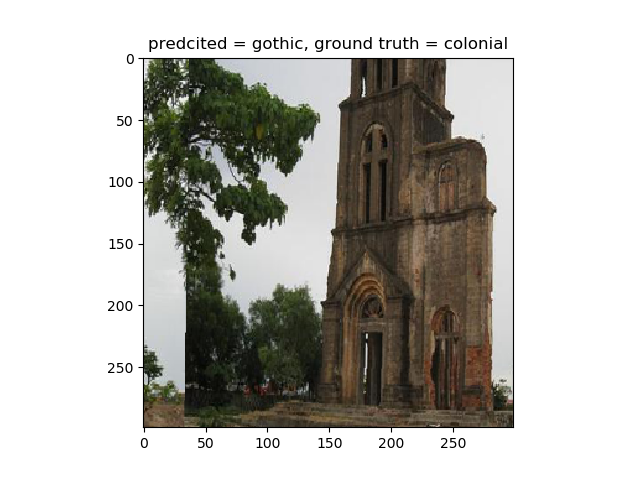

Text(0.5,1,'predcited = gothic, ground truth = colonial')

In [18]:
(err,(img, yClass0, predClass0)) = wrong.data[4]
plt.imshow((img+1)/2.0)
plt.title("predcited = %s, ground truth = %s" % (lables[predClass0], lables[yClass0]))

In [ ]:
''' Plotting cases where the NN is uncertain
Observation:
I looked through a few images, and those seem to truly be ambiguous cases. 
It would be interesting to see the NN performance after training on a more carefully curated dataset.
'''

<IPython.core.display.Javascript object>


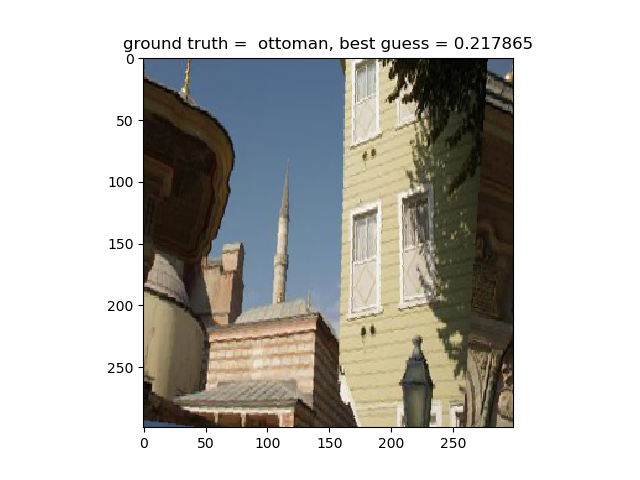

[ 0.05860228  0.20770513  0.04551222  0.11361942  0.00889429  0.00604457
  0.10159056  0.21786527  0.04040239  0.19976388]


In [21]:
(best, (img, yClass0, pred0)) = uncertain.data[3]
plt.imshow((img+1)/2.0)
plt.title("ground truth =  %s, best guess = %f" % (lables[yClass0], -best))
print(pred0)

In [24]:
''' Plotting the confusion matirx
Three obvervations here:
- for most categories the accuracy is actually higher than 65%
- the second worst category is the 'ottoman architecture', which also was the data set with the lowest quality sample images
- the NN struggles to discern modern-postmodern (not really surprising IMHO)
'''

" Plotting the confusion matirx\nThree obvervations here:\n- for most categories the accuracy is actually higher than 65%\n- the second worst category is the 'ottoman architecture', which also was the data set with the lowest quality sample images\n- the NN struggles to discern modern-postmodern (not really surprising IMHO)\n"

<IPython.core.display.Javascript object>


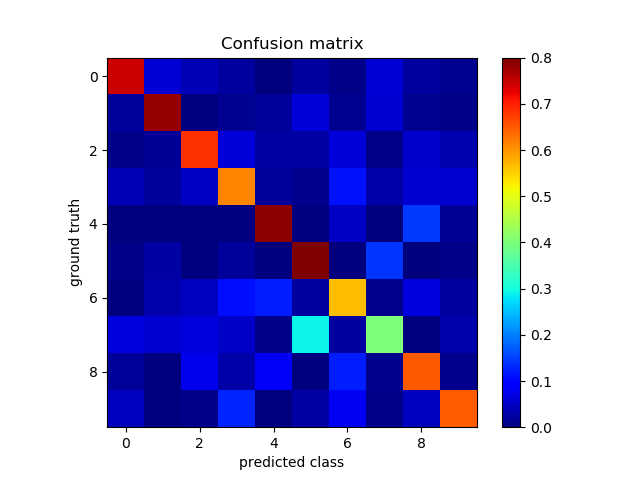

Text(0,0.5,'ground truth')

In [22]:
fig = plt.imshow(CM, cmap = 'jet')
plt.colorbar(fig)
plt.title("Confusion matrix")
plt.xlabel("predicted class")
plt.ylabel("ground truth")

In [23]:
lables

{0: 'artdeco',
 1: 'brutalist',
 2: 'classical',
 3: 'colonial',
 4: 'gothic',
 5: 'modern',
 6: 'ottoman',
 7: 'postmodern',
 8: 'romanesque',
 9: 'tudor'}